# Gender Classification from Urdu Audio

## 1. Dataset Structure and Label Parsing

### 1.1 Import Libraries and set Dataset path

In [4]:
import os
import pandas as pd

DATASET_PATH = "/kaggle/input/urdu-speech-dataset/files"

### 1.2 Label Parsing


In [5]:
data = []

for speaker_folder in os.listdir(DATASET_PATH):
    speaker_path = os.path.join(DATASET_PATH, speaker_folder)

    if not os.path.isdir(speaker_path):
        continue
 
    speaker_id = speaker_folder[:2]
    gender = speaker_folder[2]          
    native_status = speaker_folder[3]   
    age_group = speaker_folder[4:]      

    for wav_file in os.listdir(speaker_path):
        if wav_file.endswith(".wav"):
            word_id = wav_file[-7:-4]   

            data.append({
                "speaker_id": speaker_id,
                "gender": gender,
                "native": native_status,
                "age_group": age_group,
                "word_id": word_id,
                "file_path": os.path.join(speaker_path, wav_file)
            })
 
df = pd.DataFrame(data)

print(df.head())
print(df["gender"].value_counts())

  speaker_id gender native age_group word_id  \
0         AJ      M      N        G2     012   
1         AJ      M      N        G2     026   
2         AJ      M      N        G2     022   
3         AJ      M      N        G2     091   
4         AJ      M      N        G2     148   

                                           file_path  
0  /kaggle/input/urdu-speech-dataset/files/AJMNG2...  
1  /kaggle/input/urdu-speech-dataset/files/AJMNG2...  
2  /kaggle/input/urdu-speech-dataset/files/AJMNG2...  
3  /kaggle/input/urdu-speech-dataset/files/AJMNG2...  
4  /kaggle/input/urdu-speech-dataset/files/AJMNG2...  
gender
M    2000
F     500
Name: count, dtype: int64


## 2. Data Integrity Checks

### 2.1 Import Libraries

In [10]:
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### 2.2 Check Data Integrity

In [9]:
sample_rates = []
durations = []
corrupted_files = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    file_path = row["file_path"]

    try:
        audio, sr = librosa.load(file_path, sr=None)  
        sample_rates.append(sr)
        durations.append(len(audio) / sr)

    except Exception as e:
        corrupted_files.append(file_path)

sample_rates = np.array(sample_rates)
durations = np.array(durations)

print("Unique sample rates:", np.unique(sample_rates))
print("Total corrupted files:", len(corrupted_files))
print("Duration stats (seconds):")
print("Min:", durations.min())
print("Max:", durations.max())
print("Mean:", durations.mean())

100%|██████████| 2500/2500 [00:34<00:00, 72.39it/s] 

Unique sample rates: [16000]
Total corrupted files: 0
Duration stats (seconds):
Min: 0.39975
Max: 0.901
Mean: 0.5489795


### 2.3 Duration Visualization

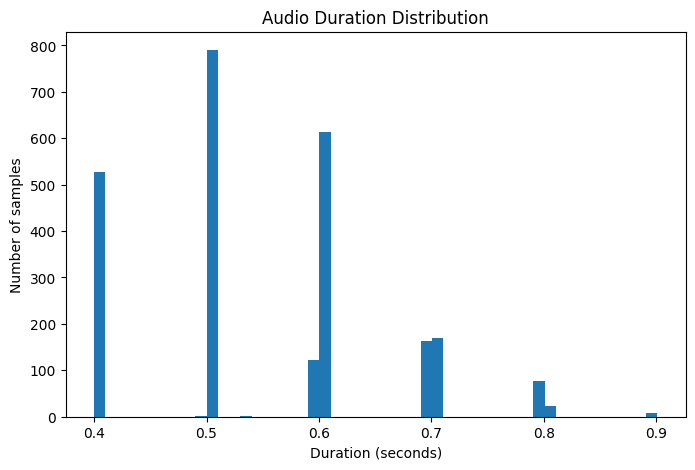

In [11]:
PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)


plt.figure(figsize=(8, 5))
plt.hist(durations, bins=50)
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of samples")
plt.title("Audio Duration Distribution")

plot_path = os.path.join(PLOTS_DIR, "audio_duration_distribution.png")
plt.savefig(plot_path)
plt.show()
plt.close()
